## Cat vs Dog classifier with Mislabaled data
This notebook walks you through training a Cat vs Dog classifier which includes mislabeled data. Initialy the training data set is uderstood and then different neural net models with different loss functions and methodologies are tested.




In [1]:
%matplotlib inline

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from pathlib import Path
from tqdm.notebook import tqdm
from PIL import Image

## Download the dataset

In [3]:
import requests

def download_file_from_google_drive(id, destination, total_size=0):
    """ General method for downloading from Google Drive.
    Doesn't require using API or having credentials
    :param id: Google Drive id for file (constant even if filename changes)
    :param destination: directory where to download the file
    """
    URL = "https://docs.google.com/uc?export=download"

    session = requests.Session()

    response = session.get(URL, params = { 'id' : id }, stream = True)
    token = get_confirm_token(response)

    if token:
        params = { 'id' : id, 'confirm' : token }
        response = session.get(URL, params = params, stream = True)

    save_response_content(response, destination, total_size)    

def get_confirm_token(response):
    """ Part of keep-alive method for downloading large files from Google Drive
    Discards packets of data that aren't the actual file
    :param response: session-based google query
    :return: either datapacket or discard unneeded data
    """
    for key, value in response.cookies.items():
        if key.startswith('download_warning'):
            return value

    return None

def save_response_content(response, destination, total_size=0):
    CHUNK_SIZE = 32768

    with tqdm(desc=destination, total=total_size, unit='B', unit_scale=True) as pbar:
        with open(destination, "wb") as f:
            for chunk in response.iter_content(CHUNK_SIZE):
                if chunk: # filter out keep-alive new chunks
                    pbar.update(CHUNK_SIZE)
                    f.write(chunk)
                
    print('Download Complete')

file_id = '1NbeXE_vX-v7RO1WTOlZgIP0gfRGSD01B'
destination = './dogscats.zip'
download_file_from_google_drive(file_id, destination, total_size=707684086)


Download Complete


## Extract the zip file

In [4]:
import zipfile
with zipfile.ZipFile(destination, 'r') as zip_ref:
    zip_ref.extractall('./')

In [5]:
data_path = Path('./dataset').absolute()
print(data_path)

/content/dataset


In [6]:
print(os.listdir(data_path))

['test2', 'train', 'valid']


## Load data names and categories into a Pandas dataframe
The following function discovers the filenames and categories

In [ ]:
from os import fspath
def create_df(datapath : Path) -> pd.DataFrame:
    """
    Function to create a dataframe from a directory of jpgs
    
    Parameters:
    datapath (pathlib Path): path to the top level directory for training or validation
    
    Returns:
    df: Pandas dataframe consisting of 'filename' and 'category' columns
    """ 
    
    filenames = list(datapath.glob('**/*.jpg'))
    categories = []
    for filename in filenames:
        category = filename.stem.split('.')[0]
        categories.append(category)
    #fspath changes pathlib posixpath to str
    df = pd.DataFrame({
        'filename': [fspath(f) for f in filenames],
        'category': categories
    })

    return df

## Create dataframes for training and validation

In [ ]:
df_train = create_df(data_path.joinpath('train'))
df_val = create_df(data_path.joinpath('valid'))

## Function to display the training and validation data with their labels. 
Describe the datasets, the class counts, and anything else of note.

********************************* Training data ************************


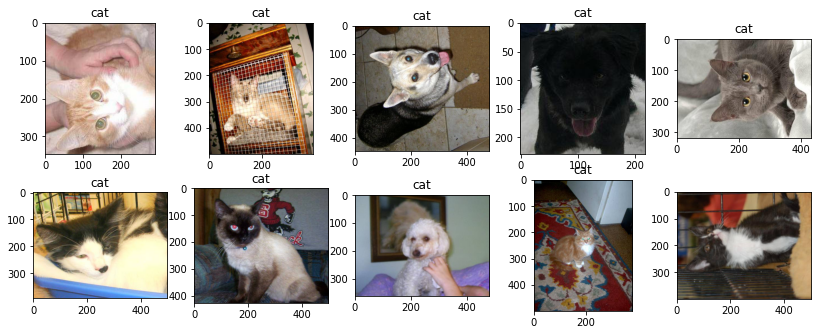

********************************* validation data ************************


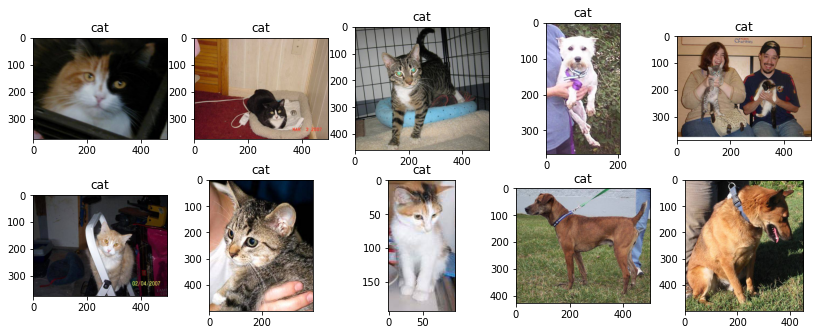

In [ ]:
# Here is a little something to help you get started
def show_data():
  print("********************************* Training data ************************")
  for i in range(10):
    img = Image.open(df_train.iloc[i]['filename'])
    plt.title(df_train.iloc[i]['category'])
    plt.subplot(2,5, i+1)
    plt.imshow(img)
  plt.subplots_adjust(top = 2, bottom=1, left = 0.2, right= 2)
  plt.show()
  print("********************************* validation data ************************")
  for i in range(10):
    img = Image.open(df_val.iloc[i]['filename'])
    plt.title(df_val.iloc[i]['category'])
    plt.subplot(2,5, i+1)
    plt.imshow(img)
  plt.subplots_adjust(top = 2, bottom=1, left = 0.2, right= 2)
  plt.show()



show_data()



# index=13
# img = Image.open(df_train.iloc[index]['filename'])
# plt.title(df_train.iloc[index]['category'])
# plt.axis('off')
# plt.imshow(img);

### Data Sample
Due to the large size of the dataset, sample a portion of the data for model building. The numbers here are a suggestion, feel free to use as much of the provided data as you want. I usually start with a small subset to get functions working correctly rather than wasting a lot of time waiting for code to break.

In [ ]:
#3200
df_train = df_train.sample(1500)
df_val = df_val.sample(500)

### Pytorch Model
Below is the basic model used based on a resnet-18 pretrained model


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.utils.data import DataLoader, Dataset
import torchvision
from torchvision import models, transforms
import time
import os
import copy

In [ ]:
import torchvision.transforms.functional as TF
import random
from typing import Sequence

class MyRotateTransform:
    def __init__(self, angles: Sequence[int]):
        self.angles = angles

    def __call__(self, x):
        angle = random.choice(self.angles)
        return TF.rotate(x, angle)

In [ ]:
# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
        MyRotateTransform([0,-90]),
        transforms.RandomHorizontalFlip(),
        transforms.RandomResizedCrop(224, scale=(0.96, 1.0), ratio=(0.95, 1.05)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'valid': transforms.Compose([
        transforms.Resize([224,224]),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

In [ ]:
class Dataset(object):
    """An abstract class representing a Dataset.
    All other datasets should subclass it. All subclasses should override
    ``__len__``, that provides the size of the dataset, and ``__getitem__``,
    supporting integer indexing in range from 0 to len(self) exclusive.
    """

    def __getitem__(self, index):
        raise NotImplementedError

    def __len__(self):
        raise NotImplementedError

    def __add__(self, other):
        return ConcatDataset([self, other])

In [ ]:
class DatasetCatsAndDogs(Dataset):
    def __init__(self, df, transform=None):
        self.df = df.copy()
        self.transform = transform
        self.classes = ['cat','dog']
        self.int2category = {k:v for k,v in enumerate(self.classes)}
        self.category2int = {v:k for k,v in self.int2category.items()}
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, index):
        img =  Image.open(self.df.iloc[index]['filename'])
        if 'category' in self.df.columns:
            label = self.df.iloc[index]['category']
        else:
            label = None
        
        if self.transform is not None:
            img = self.transform(img)
        
        if label is None:
            return img
        else:
            return img, np.array(self.category2int[label])

In [ ]:
train_dataset = DatasetCatsAndDogs(df_train, transform=data_transforms['train'])
valid_dataset = DatasetCatsAndDogs(df_val, transform=data_transforms['valid'])

In [ ]:
num_workers=0
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True, num_workers=num_workers)
val_loader = DataLoader(valid_dataset, batch_size=8, shuffle=False, num_workers=num_workers)

In [ ]:
def imshow(inp, title=None, imgsize=3):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    fig = plt.figure(figsize=(imgsize*2,imgsize*2))
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.axis('off')

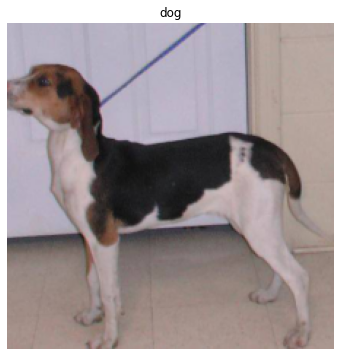

In [ ]:
index = int(np.random.randint(0,high=len(df_train),size=1,dtype=int))
img, lab = train_dataset.__getitem__(index)
imshow(img,train_dataset.int2category[int(lab)])

In [ ]:
def show_batch(inp, title=None, imgsize=3):
    """show a batch of data with their titles"""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    sz = inp.shape[0]
    bs = inp.shape[1]/inp.shape[0]
    rows = int(bs**0.5)
    cols = int(bs/rows)
    fig, axs = plt.subplots(rows, cols, figsize=(4*cols,4*rows))
    for i, ax in enumerate(axs.flatten()):
        img = Image.fromarray(np.uint8(inp[:,(i*sz):(i+1)*sz,:]*255.0))
        ax.imshow(img)
        if title is not None:
            ax.set_title(title[i])
        ax.axis('off')
    plt.tight_layout()
    return fig, axs

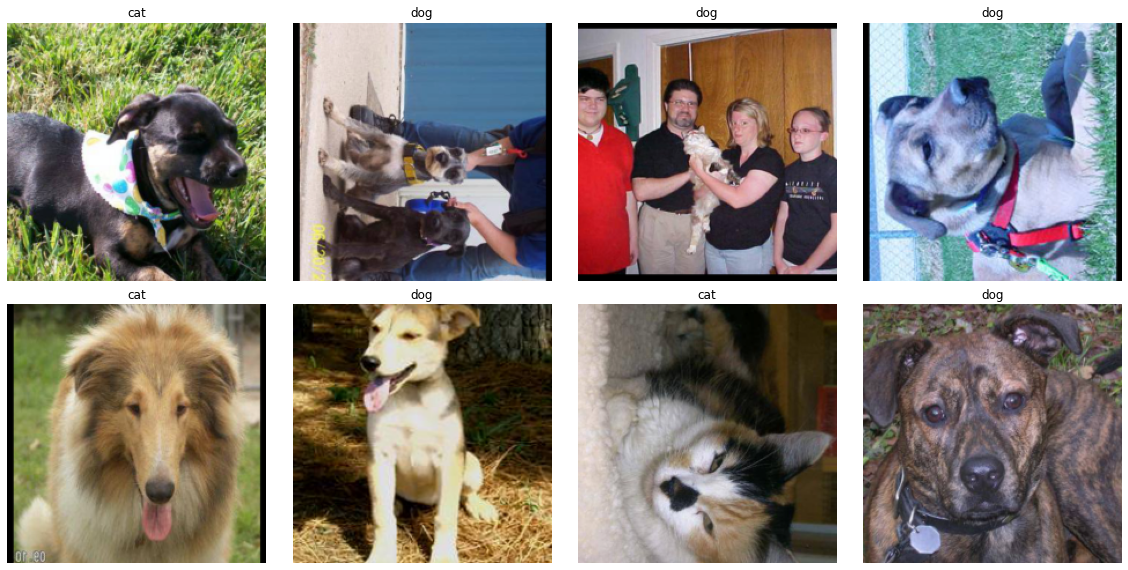

In [ ]:
# Get a batch of training data
inputs, classes = next(iter(train_loader))
# Make a grid from batch
sample_train_images = torchvision.utils.make_grid(inputs,padding=0)
show_batch(sample_train_images, title=[train_dataset.int2category[int(v)] for v in classes.numpy()]);

In [ ]:
print(f'Train dataset size: {len(train_dataset)}')
print(f'Validation dataset size: {len(valid_dataset)}')

Train dataset size: 1500
Validation dataset size: 500


In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [ ]:
def train_model(model, dataloaders, criterion, optimizer, scheduler, num_epochs):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            tk0 = tqdm(iter(dataloaders[phase]), total=int(len(dataloaders[phase])))
            counter = 0
            # Iterate over data.
            for bi, d in enumerate(tk0):
            #for inputs, labels in iter(dataloaders[phase]):
                inputs, labels = d
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
                
                counter += 1
                tk0.set_postfix(loss=(running_loss / (counter * dataloaders[phase].batch_size)),
                                acc = float(running_corrects.double() / (counter * dataloaders[phase].batch_size)) )
                
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / (len(dataloaders[phase]) * dataloaders[phase].batch_size)
            epoch_acc = running_corrects.double() / (len(dataloaders[phase]) * dataloaders[phase].batch_size)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [ ]:
model_ft = models.resnet18(pretrained=True)
num_ftrs = model_ft.fc.in_features
# Freeze the model
for param in model_ft.parameters():
    param.requires_grad = False

# Parameters of newly constructed modules have requires_grad=True by default    
model_ft.fc = nn.Linear(num_ftrs, len(train_dataset.classes))

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 2 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=2, gamma=0.1)

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/hub/checkpoints/resnet18-5c106cde.pth


In [ ]:
dataloaders = {'train': train_loader, 'val': val_loader}

In [ ]:
model_ft = train_model(model_ft, dataloaders, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=4)

Epoch 0/3
----------



train Loss: 0.6984 Acc: 0.6203



val Loss: 0.7936 Acc: 0.5992

Epoch 1/3
----------



train Loss: 0.7177 Acc: 0.6303



val Loss: 0.8387 Acc: 0.5893

Epoch 2/3
----------



train Loss: 0.6077 Acc: 0.6775



val Loss: 0.7558 Acc: 0.6052

Epoch 3/3
----------



train Loss: 0.5884 Acc: 0.6915



val Loss: 0.7422 Acc: 0.6012

Training complete in 1m 6s
Best val Acc: 0.605159


## Training metrics
Modifying the training code to log some metrics after each epoch and plotting accuracy and Loss against the training and validation data.  

In [ ]:
def calc_metrics(n_class_correct, n_class_samples,mode):
  TN = n_class_correct[0]
  TP = n_class_correct[1]
  FP = n_class_samples[0] - n_class_correct[0]
  FN = n_class_samples[1] - n_class_correct[1]
  recall = TP/(FN+TP)
  precision = TP/(TP+FP)
  f1_score = (2*recall*precision)/(recall+precision)
  # classes = ['cat','dog']
  dog_accuracy = n_class_correct[1]/n_class_samples[1]
  cat_accuracy = n_class_correct[0]/n_class_samples[0]
  print(mode)
  print(f'accuracy for dog images:    {dog_accuracy}')
  print(f'accuracy for cat images:    {cat_accuracy}')
  print(f'F1 score:   {f1_score},   Recall: {recall} ,  precision: {precision}')

  # return dog_accuracy, cat_accuracy, f1_score, precision, recall

def plot_accuracy_loss(train_accuracy, train_loss, val_accuracy, val_loss):
    fig = plt.figure()
    ax1 = plt.subplot2grid((2,1), (0,0))
    ax2 = plt.subplot2grid((2,1), (1,0), sharex=ax1)
    ax1.plot(train_accuracy, label="train_acc")
    ax1.plot(val_accuracy, label="val_acc")
    ax1.legend(loc=2)
    ax2.plot(train_loss, label="train_loss")
    ax2.plot(val_loss, label="val_loss")
    ax2.legend(loc=2)
    plt.show()

  # plt.plot(train_accuracy)

  # plt.show()  
  


def train_model(model, dataloaders, criterion, optimizer, scheduler, num_epochs):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    train_accuracy, val_accuracy = [], []
    train_loss, val_loss = [], []
    for epoch in range(num_epochs):
        
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            n_class_correct = [0 for i in range(2)]
            n_class_samples = [0 for i in range(2)]
            
            
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            tk0 = tqdm(iter(dataloaders[phase]), total=int(len(dataloaders[phase])))
            counter = 0
            # Iterate over data.
            for bi, d in enumerate(tk0):
            #for inputs, labels in iter(dataloaders[phase]):
                inputs, labels = d
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                for i in range(len(labels)):
                  if preds[i] == labels[i]:
                    n_class_correct[labels[i]]+= 1
                  n_class_samples[labels[i]] += 1
                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
                
                counter += 1
                tk0.set_postfix(loss=(running_loss / (counter * dataloaders[phase].batch_size)),
                                acc = float(running_corrects.double() / (counter * dataloaders[phase].batch_size)) )

            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / (len(dataloaders[phase]) * dataloaders[phase].batch_size)
            epoch_acc = running_corrects.double() / (len(dataloaders[phase]) * dataloaders[phase].batch_size)
            if phase == 'train':
                train_accuracy.append(epoch_acc)
                train_loss.append(epoch_loss)
            elif phase == 'val':
                val_accuracy.append(epoch_acc)
                val_loss.append(epoch_loss)
            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))
            calc_metrics(n_class_correct,n_class_samples,phase)
            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    plot_accuracy_loss(train_accuracy, train_loss, val_accuracy, val_loss)
    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

Epoch 0/4
----------



train Loss: 0.5994 Acc: 0.6968
train
accuracy for dog images:    0.6711956521739131
accuracy for dog images:    0.725130890052356
F1 score:   0.6861111111111111,   Recall: 0.6711956521739131 ,  precision: 0.7017045454545454



val Loss: 0.7441 Acc: 0.6052
val
accuracy for dog images:    0.5703125
accuracy for dog images:    0.6516393442622951
F1 score:   0.5995893223819301,   Recall: 0.5703125 ,  precision: 0.6320346320346321

Epoch 1/4
----------



train Loss: 0.5993 Acc: 0.6922
train
accuracy for dog images:    0.6589673913043478
accuracy for dog images:    0.7277486910994765
F1 score:   0.6787963610916724,   Recall: 0.6589673913043478 ,  precision: 0.6998556998556998



val Loss: 0.7522 Acc: 0.6111
val
accuracy for dog images:    0.5859375
accuracy for dog images:    0.6475409836065574
F1 score:   0.6097560975609756,   Recall: 0.5859375 ,  precision: 0.635593220338983

Epoch 2/4
----------



train Loss: 0.5867 Acc: 0.7074
train
accuracy for dog images:    0.686141304347826
accuracy for dog images:    0.731675392670157
F1 score:   0.6984785615491009,   Recall: 0.686141304347826 ,  precision: 0.7112676056338029



val Loss: 0.7468 Acc: 0.6151
val
accuracy for dog images:    0.6171875
accuracy for dog images:    0.6229508196721312
F1 score:   0.6245059288537549,   Recall: 0.6171875 ,  precision: 0.632

Epoch 3/4
----------



train Loss: 0.5873 Acc: 0.7061
train
accuracy for dog images:    0.6929347826086957
accuracy for dog images:    0.7225130890052356
F1 score:   0.6995884773662552,   Recall: 0.6929347826086957 ,  precision: 0.7063711911357341



val Loss: 0.7443 Acc: 0.6091
val
accuracy for dog images:    0.609375
accuracy for dog images:    0.6188524590163934
F1 score:   0.6178217821782178,   Recall: 0.609375 ,  precision: 0.6265060240963856

Epoch 4/4
----------



train Loss: 0.6032 Acc: 0.6928
train
accuracy for dog images:    0.6644021739130435
accuracy for dog images:    0.7238219895287958
F1 score:   0.6810584958217271,   Recall: 0.6644021739130435 ,  precision: 0.6985714285714286



val Loss: 0.7427 Acc: 0.6091
val
accuracy for dog images:    0.6015625
accuracy for dog images:    0.6270491803278688
F1 score:   0.6147704590818364,   Recall: 0.6015625 ,  precision: 0.6285714285714286



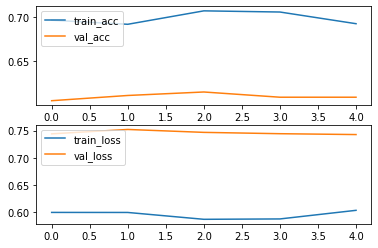

Training complete in 1m 23s
Best val Acc: 0.615079


In [ ]:
model_ft = train_model(model_ft, dataloaders, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=5)

## Loss Functions
The model takes an image and predicts a categorical output, a dog or cat. </br>

* In our question, since we are dealing with two tensors as output, cross entrpy loss is a valid loss function. If we had a single tensor as our output Binary cross entropy loss would have been a good option.
* It is the preferred loss function under the inference framework of maximum likelihood.
* Hinge loss and Squared Hinge loss are also options that can be used for single outputs.  


## Discussing the advantages and disadvantages of ML models with binary and multiclass outputs

* Models that can only predict cats and dogs are considered simpler and less sophisticated in comparison to models that can distingush multiple  classes
* As the model gets more complicated the number of parameters increase and this makes it more costly to train the model. More resources are needed and traning time can be very long.
* Also, As more parameters are introduced to the system, the loss function might become harder to converge. There is a high probability that the loss function would be stuck in a local minimum vs the global minimum and this makes it hard to train these models.
* The correlation Matrix between different classes might be high in image classifiaction. For example, if we have classes for tigers and cats, since these two animals have a lot of patterns in comman, this makes it harder for the model to distinguish between them since the correlation matrix between these two animals is very high.
* Also, more data is needed to train a classifier with more classes


## Improvements 

* The training job given here is a standard pytorch training cycle
* After tuning some of the parameters not a significant advance in accuracy was achived
* Further improvements were needed
* After reviewing the data, it can be seen that our data has noisy labels. Most of the data in the cat folder or the dog folder are labeled incorrectly. 
* Three methods were used here to solve this issues:
* 1- Using a custom loss function instead of the crossentropy loss that would put weights on labels instead of considering them a binary value. (this approach made minor imporvements. The code is included below)
* 2- Using Pytorch weight matrix for different classes. This would give different weights to different classes in our model. In the case that we have an unbalanced data set, we can use this to put more focus on the class that has lower number of samples in our training dataset.
* 3- The final approach is trying to do unsupervised learning on the models and using a kmeans model to identify outliers for each of the folders.

In [ ]:
class CLSLoss(object):
    def __init__(self, num_classes=2, ls=False, eps=0.3, device = device):
        self.cls_loss = nn.CrossEntropyLoss()
        self.device = torch.device(device)
        self.ls = ls

        if self.ls:
            self.num_classes = num_classes
            self.epsilon = eps
            self.logsoftmax = nn.LogSoftmax(dim=1)
        
    def __call__(self, predictions, targets):
        if not self.ls:
            loss = self.cls_loss(predictions, targets)
        else:
            log_probs = self.logsoftmax(predictions)
            targets = torch.zeros(log_probs.size()).scatter_(1, targets.unsqueeze(1).data.cpu(), 1).to(self.device)
            targets = (1 - self.epsilon) * targets + self.epsilon / self.num_classes
            loss = (-targets * log_probs).mean(0).sum()
        return loss

In [ ]:
model_ft = models.resnet18(pretrained=True)
num_ftrs = model_ft.fc.in_features
# Freeze the model
for param in model_ft.parameters():
    param.requires_grad = False

# Parameters of newly constructed modules have requires_grad=True by default    
model_ft.fc = nn.Linear(num_ftrs, len(train_dataset.classes))

model_ft = model_ft.to(device)

# criterion = nn.CrossEntropyLoss()
# Replaced the loss function with the custom loss function defined above
criterion = CLSLoss(num_classes=2 ,ls = True, eps = 0.3, device = device)
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 2 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=2, gamma=0.1)



In [ ]:
model_ft = train_model(model_ft, dataloaders, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=2)

In [ ]:
class Identity(nn.Module):
    def __init__(self):
        super(Identity, self).__init__()
        
    def forward(self, x):
        return x

model_outlier = torchvision.models.resnet18(pretrained=True)

# Freeze the model
for param in model_outlier.parameters():
    param.requires_grad = False
model_outlier = model_outlier.to(device)
model_outlier.fc = Identity()





In [ ]:
def train_model(model, data_loader):
    features_list = []
    for i,(image, labels) in enumerate(data_loader):
      image = image.to(device)
      pred = model(image)
      features_list.append((pred.cpu().numpy())[0])
    return features_list

In [ ]:
transform = transforms.Compose([
        transforms.RandomResizedCrop(224, scale=(0.96, 1.0), ratio=(0.95, 1.05)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])

df_train_dog = create_df(data_path.joinpath('train/dogs'))
df_train_cat = create_df(data_path.joinpath('train/cats'))
df_val_dog = create_df(data_path.joinpath('valid/dogs'))
df_val_cat = create_df(data_path.joinpath('valid/cats'))

df_train_dog = df_train_dog.iloc[0:1000]
df_train_cat = df_train_cat.iloc[0:1000]
df_val_dog = df_val_dog.iloc[0:100]
df_val_cat = df_val_cat.iloc[0:100]

train_dataset_dog = DatasetCatsAndDogs(df_train_dog, transform=transform)
valid_dataset_dog = DatasetCatsAndDogs(df_val_dog, transform=transform)
train_dataset_cat = DatasetCatsAndDogs(df_train_cat, transform=transform)
valid_dataset_cat = DatasetCatsAndDogs(df_val_cat, transform=transform)

train_loader_dog = DataLoader(train_dataset_dog, batch_size=1, shuffle=False, num_workers=num_workers)
val_loader_dog = DataLoader(valid_dataset_dog, batch_size=1, shuffle=False, num_workers=num_workers)
train_loader_cat = DataLoader(train_dataset_cat, batch_size=1, shuffle=False, num_workers=num_workers)
val_loader_cat = DataLoader(valid_dataset_cat, batch_size=1, shuffle=False, num_workers=num_workers)

In [ ]:
features_list_train_dog = train_model(model_outlier, train_loader_dog)
features_list_val_dog = train_model(model_outlier, val_loader_dog)
features_list_train_cat = train_model(model_outlier, train_loader_cat)
features_list_val_cat = train_model(model_outlier, val_loader_cat)

## Applying Kmeans for unsupervised learning

In [ ]:
from sklearn.cluster import KMeans

kmeans_dog_train = KMeans(n_clusters=2, random_state=0).fit(features_list_train_dog)
kmeans_dog_val = KMeans(n_clusters=2, random_state=0).fit(features_list_val_dog)
kmeans_cat_train = KMeans(n_clusters=2, random_state=0).fit(features_list_train_cat)
kmeans_cat_val = KMeans(n_clusters=2, random_state=0).fit(features_list_val_cat)


In [ ]:
badge_dog_train = 1 if np.count_nonzero(kmeans_dog_train.labels_ == 1) > np.count_nonzero(kmeans_dog_train.labels_ == 0) else 0
badge_dog_val = 1 if np.count_nonzero(kmeans_dog_val.labels_ == 1) > np.count_nonzero(kmeans_dog_val.labels_ == 0) else 0
badge_cat_train = 1 if np.count_nonzero(kmeans_cat_train.labels_ == 1) > np.count_nonzero(kmeans_cat_train.labels_ == 0) else 0
badge_cat_val = 1 if np.count_nonzero(kmeans_cat_val.labels_ == 1) > np.count_nonzero(kmeans_cat_val.labels_ == 0) else 0


In [ ]:
print(badge_cat_train, badge_cat_val, badge_dog_train, badge_dog_val)
print(np.count_nonzero(kmeans_dog_train.labels_ == 1))
print(np.count_nonzero(kmeans_dog_train.labels_ == 0))

0 0 0 1
400
600


In [ ]:
df_train_dog['outlier'] = kmeans_dog_train.labels_ 
df_train_dog = df_train_dog.loc[df_train_dog['outlier']== badge_dog_train]
print(len(df_train_dog))

df_train_cat['outlier'] = kmeans_cat_train.labels_
df_train_cat = df_train_cat.loc[df_train_cat['outlier']== badge_cat_train]

df_val_dog['outlier'] = kmeans_dog_val.labels_
df_val_dog = df_val_dog.loc[df_val_dog['outlier']== badge_dog_val]

df_val_cat['outlier'] = kmeans_cat_val.labels_
df_val_cat = df_val_cat.loc[df_val_cat['outlier']== badge_cat_val]

600


In [ ]:
final_train_dataframe = pd.concat([df_train_dog,df_train_cat])
final_valid_dataframe = pd.concat([df_val_dog, df_val_cat])

## Model Evalution

Runnig the model against the test set

## Prepare test dataframe

In [ ]:
test_filenames = os.listdir(data_path.joinpath('test2'))
df_test = pd.DataFrame({
    'filename': test_filenames
})
df_test['filename'] = df_test['filename'].apply(lambda x: Path(data_path).joinpath('test2',x))
nb_samples = df_test.shape[0]
print(f'Created test set with {nb_samples} samples')

Created test set with 5000 samples


In [ ]:
test_dataset = DatasetCatsAndDogs(df_test, transform=data_transforms['valid'])
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False, num_workers=0)

Replacing the base_model variable with the new model

In [ ]:
def get_predictions(model, data_loader, classes):
    was_training = model.training
    model.eval()
    
    pout = {}
    
    tk0 = tqdm(iter(data_loader), total=int(len(data_loader)))
    
    batch = 0
    for i, inputs in enumerate(tk0):
        
        inputs = inputs.to(device)

        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        
        pout = {**pout, **{batch+iv:classes[int(v)] for iv, v in enumerate(preds.numpy())}}
        batch += min((len(preds),data_loader.batch_size))
                
    model.train(mode=was_training)
    
    return pout

In [ ]:
predictions = get_predictions(model_ft, test_loader, test_dataset.classes)

In [ ]:
df_test['prediction'] = pd.DataFrame(data={'prediction':predictions})

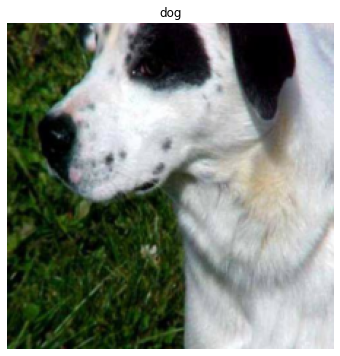

In [ ]:
index=10
img = test_dataset.__getitem__(index)
imshow(img,df_test.iloc[index]['prediction'])